In [224]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [225]:
feature_class = pd.read_csv('feature_class.csv')
train_df, test_df = train_test_split(feature_class, test_size=0.2, random_state=42) 

In [227]:
input_size = 15  
num_classes = 6  

model = SimpleNN(input_size, num_classes)
loss = nn.CrossEntropyLoss()
optimize = optim.Adam(model.parameters(), lr=0.001)

In [228]:
feature_torch = torch.tensor(train_df.drop('label',axis = 1).values, dtype=torch.float32)
label_torch = torch.tensor(train_df['label'].values,dtype=torch.int64)

feature_torch_test = torch.tensor(test_df.drop('label',axis = 1).values, dtype=torch.float32)
label_torch_test = torch.tensor(test_df['label'].values,dtype=torch.int64)


In [229]:
train_dataset = TensorDataset(feature_torch, label_torch)
test_dataset = TensorDataset(feature_torch_test, label_torch_test)

In [230]:
batch_size = 12

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [231]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [232]:
y_pred = []
y_test = []
def validate(last = False):

    model.eval()
    correct = 0
    total = 0
    for features, labels in test_loader: 
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)

        if last:
            y_pred.append(predicted.cpu().numpy())
            y_test.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [233]:
# train the model

epochs = 250
running_loss = 0

# store the loss and accuracy
training_loss_list = []
valid_acc_list = []

for epoch in range(epochs):
    for i, (features, labels) in enumerate(train_loader):

        features, labels = features.to(device), labels.to(device)

        optimize.zero_grad()
        outputs = model.forward(features)
        loss_value = loss(outputs, labels)
        loss_value.backward()
        optimize.step()
        running_loss += loss_value.item()
        labels_correct = torch.argmax(outputs, dim=1) == labels

    if_last = True if epoch == (epochs-1) else False 
    valid_acc = validate(if_last)
    print(f'Epoch: {epoch+1}/{epochs}..',
        f'Training Loss: {running_loss/len(test_loader):.3f}',
        f'Training Accuracy: {100*len(labels_correct)/len(labels):.3f}%',
        f'Validation Accuracy: {valid_acc:.3f}%')
    
    training_loss_list.append(running_loss/len(test_loader))
    valid_acc_list.append(valid_acc)
    
    running_loss = 0.0

Epoch: 1/250.. Training Loss: 7.359 Training Accuracy: 100.000% Validation Accuracy: 18.159%
Epoch: 2/250.. Training Loss: 6.997 Training Accuracy: 100.000% Validation Accuracy: 38.308%
Epoch: 3/250.. Training Loss: 6.609 Training Accuracy: 100.000% Validation Accuracy: 38.060%
Epoch: 4/250.. Training Loss: 6.356 Training Accuracy: 100.000% Validation Accuracy: 47.761%
Epoch: 5/250.. Training Loss: 6.015 Training Accuracy: 100.000% Validation Accuracy: 73.632%
Epoch: 6/250.. Training Loss: 5.116 Training Accuracy: 100.000% Validation Accuracy: 76.368%
Epoch: 7/250.. Training Loss: 5.032 Training Accuracy: 100.000% Validation Accuracy: 77.114%
Epoch: 8/250.. Training Loss: 5.024 Training Accuracy: 100.000% Validation Accuracy: 78.109%
Epoch: 9/250.. Training Loss: 5.010 Training Accuracy: 100.000% Validation Accuracy: 77.612%
Epoch: 10/250.. Training Loss: 5.007 Training Accuracy: 100.000% Validation Accuracy: 78.109%
Epoch: 11/250.. Training Loss: 4.996 Training Accuracy: 100.000% Vali

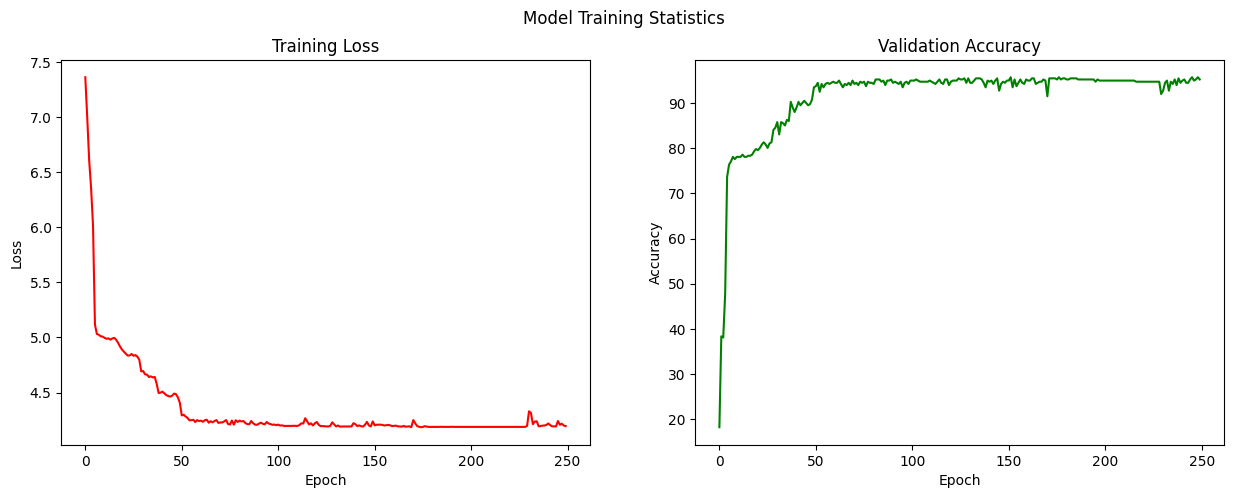

In [234]:
# plot the training loss and validation accuracy in seperate plots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(training_loss_list, color='red')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(valid_acc_list, color='green')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

plt.suptitle('Model Training Statistics')
plt.show()

In [235]:
y_pred = list(np.concatenate(y_pred))
confusion = confusion_matrix(y_test,y_pred)
confusion

array([[ 68,   1,   2,   0,   0,   2],
       [  1, 120,   1,   0,   1,   2],
       [  2,   0,  91,   0,   0,   0],
       [  4,   0,   0,  37,   0,   0],
       [  0,   0,   0,   0,  33,   0],
       [  1,   1,   1,   0,   0,  34]])

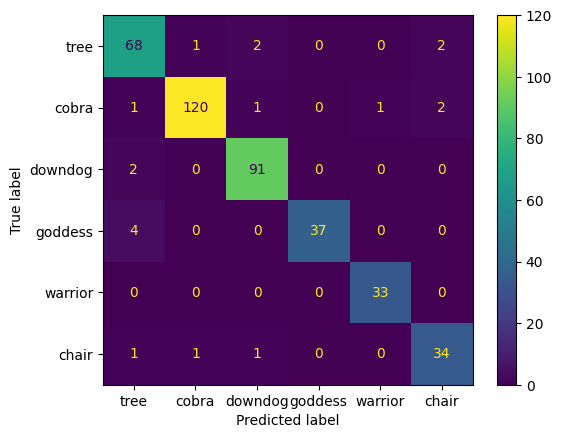

In [236]:
disp = ConfusionMatrixDisplay(confusion, display_labels = ['tree','cobra','downdog','goddess','warrior','chair'])
disp.plot()

In [237]:

target_names = ['tree','cobra','downdog_data','goddess','warrior','chair']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        tree       0.89      0.93      0.91        73
       cobra       0.98      0.96      0.97       125
downdog_data       0.96      0.98      0.97        93
     goddess       1.00      0.90      0.95        41
     warrior       0.97      1.00      0.99        33
       chair       0.89      0.92      0.91        37

    accuracy                           0.95       402
   macro avg       0.95      0.95      0.95       402
weighted avg       0.95      0.95      0.95       402



In [238]:
# save the model
torch.save(model.state_dict(), 'model.pth')